<a href="https://colab.research.google.com/github/adin786/autotrader-analysis/blob/main/autotrader_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autotrader analysis
Data source: [www.autotrader.co.uk](https://www.autotrader.co.uk/)
 
This is an analysis of used car adverts found on Autotrader.co.uk.  Data from each advert was web-scraped from in order to explore how selling price is influenced by factors such as mileage, age, features etc.  The end result is to build a model to help me decide an appropriate selling price for my own car, an Audi A6.
 
### Table of Contents
1. [Load data](#load-data)
2. [Clean data](#clean-data)
3. [Create new features](#create-new-features)
4. [Data exploration (categorical)](#data-exploration-numerical)
5. [Data exploration (categorical)](#data-exploration-categorical)
6. [Model building (simple)](#model-building-simple)


 
### Assumptions
- Autotrader doesn't know the eventual sale price, only the advertised price.  So this analysis doesn't exactly look at the market price that buyers are willing to pay, instead it is the price that my car could be advertised at in order to match similarly specced cars.
- I only looked at high level summary data from the main search page not each adverts detail page.
 
### Prerequisites
This notebook requires that the data already be scraped a and stored in a .csv file.  I have not uploaded my scraped dataset directly as that data technically belongs to AutoTrader. 

### Web-scraper
The webscraper uses requests and beautifulsoup4.  Code at [github.com/adin786/autotrader-analysis](https://github.com/adin786/autotrader-analysis)
 
To replicate this analysis the following must be completed:
- Using the search function of the AutoTrader website, adverts were filtered for `make='Audi'` and `model='A6'`.  
- The search URL was copied and used as an input to the webscraper code.
- The webscraper was configured to loop over the first 100 search pages, extract advert summary details, and store them in a .csv file.  

The same process could be easily repeated for any other search URL, for example with a different vehicle make.  I chose not to scrape data for any and all vehicle brands as I was only interested in Audi A6 models.  I also chose to only scrape from the main search page rather than each individual advert page.  I found there was enough summary data there for a reasonable analysis. And this saved time and kept my request load on the servers low.  This may an area to come back to for further analysis in future.

<a name="load-data"></a>
# Load data


In [ ]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Import from csv
path = os.path.join('drive','MyDrive','Data', 'autotrader')
df = pd.read_csv(os.path.join(path,'scraped_autotrader.csv'))

In [ ]:
# Preview imported csv data
df.head()

,advert_id,attention_grabber,condition_value,description_full,detail_ad,distance_value,good_great_value,has_finance,id,image_count,is_allocated_stock,is_franchise_approved,is_group_stock,is_manufacturer_approved,is_multi_location_advert,is_network_stock,is_virtual_stock,key_spec_list_ad,price,search_results_advert_card,seller_location,seller_private_trade,time_of_scrape,title_ad,title_full
0,202103290721220,"Full Leather, Black Interior",NaN,skip,2.0 TDI e S line 4dr,35 miles,noanalysis,True,202103290721220,12,False,False,False,False,False,False,False,"['2010 (10 reg)', 'Saloon', '88,126 miles', '2...","£5,490",NaN,edinburgh,Private seller,2021-04-08 00:38:08.537902,Audi A6 Saloon,skip
1,202103250566697,1 Private Owner + 1 Company,NaN,skip,2.0 Sport 4dr,183 miles,noanalysis,False,202103250566697,95,False,False,False,False,False,False,False,"['2003 (03 reg)', 'Saloon', '82,154 miles', '2...","£2,000",NaN,5.0,Woodside Car Sales,2021-04-08 00:38:08.590687,Audi A6 Saloon,skip
2,202003248731394,Stunning Bespoke A6 C6 4.2LTR,NaN,skip,4.2 S line quattro 4dr,3 miles,noanalysis,False,202003248731394,20,False,False,False,False,False,False,False,"['2005 (54 reg)', 'Saloon', '121,000 miles', '...","£5,990",NaN,glasgow,Private seller,2021-04-08 00:38:08.624812,Audi A6 Saloon,skip
3,202102128981053,"Cream Leather Interior, Bose",NaN,skip,2.0 TDI ultra Black Edition S Tronic (s/s) 4dr,10 miles,noanalysis,True,202102128981053,11,False,False,False,False,False,False,False,"['2015 (15 reg)', 'Saloon', '34,500 miles', '2...","£14,490",NaN,glasgow,Private seller,2021-04-08 00:38:08.659050,Audi A6 Saloon,skip
4,202102169143343,Full Service History,NaN,skip,2.0 TDI SE 4dr,13 miles,noanalysis,True,202102169143343,15,False,False,False,False,False,False,False,"['2011 (61 reg)', 'Saloon', '62,242 miles', '2...","£7,995",NaN,falkirk,Private seller,2021-04-08 00:38:08.693502,Audi A6 Saloon,skip


In [ ]:
# Check column names and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   advert_id                   1100 non-null   int64  
 1   attention_grabber           1019 non-null   object 
 2   condition_value             11 non-null     object 
 3   description_full            1100 non-null   object 
 4   detail_ad                   1100 non-null   object 
 5   distance_value              1100 non-null   object 
 6   good_great_value            1100 non-null   object 
 7   has_finance                 1100 non-null   bool   
 8   id                          1100 non-null   int64  
 9   image_count                 1100 non-null   int64  
 10  is_allocated_stock          1000 non-null   object 
 11  is_franchise_approved       1100 non-null   bool   
 12  is_group_stock              1000 non-null   object 
 13  is_manufacturer_approved    1100 

<a name="clean-data"></a>
# Clean data


In [ ]:
# Fill blanks
df.condition_value = df.condition_value.fillna('Blank')

In [ ]:
# Fill blanks in bool features with False as blanks are these features are mostly just for new cars only.
df.is_allocated_stock = df.is_allocated_stock.fillna(False)
df.is_franchise_approved = df.is_franchise_approved.fillna(False)
df.is_group_stock = df.is_group_stock.fillna(False)
df.is_manufacturer_approved = df.is_manufacturer_approved.fillna(False)
df.is_multi_location_advert = df.is_multi_location_advert.fillna(False)
df.is_network_stock = df.is_network_stock.fillna(False)
df.is_virtual_stock = df.is_virtual_stock.fillna(False)

In [ ]:
# Strip '£' and 'miles' for conversion to int later
df.price = df.price.str.replace('£|,','')
df.distance_value = df.distance_value.str.replace(' miles','')

In [ ]:

# Drop column that isn't useful
df = df.drop(['search_results_advert_card'], axis=1)

In [ ]:

# Drop columns for title_full and description_full
# These were placeholders only
df = df.drop(['title_full'], axis=1)

In [ ]:
# Convert columns from strings to proper types
df = df.astype({'advert_id':int,
'attention_grabber': object,
'condition_value': 'category',
'description_full': object,
'detail_ad': object,
'distance_value':int,
'good_great_value':'category',
'has_finance':bool,
'id':int,
'image_count':int,
'is_allocated_stock':bool,
'is_franchise_approved':bool,
'is_group_stock':bool,
'is_manufacturer_approved':bool,
'is_multi_location_advert':bool,
'is_network_stock':bool,
'is_virtual_stock':bool,
'key_spec_list_ad':object,
'price':int,
'seller_location':object,
'seller_private_trade':'category',
'time_of_scrape':'datetime64',
'title_ad':object,
})

In [ ]:
# Check data types converted successfully
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   advert_id                 1100 non-null   int64         
 1   attention_grabber         1019 non-null   object        
 2   condition_value           1100 non-null   category      
 3   description_full          1100 non-null   object        
 4   detail_ad                 1100 non-null   object        
 5   distance_value            1100 non-null   int64         
 6   good_great_value          1100 non-null   category      
 7   has_finance               1100 non-null   bool          
 8   id                        1100 non-null   int64         
 9   image_count               1100 non-null   int64         
 10  is_allocated_stock        1100 non-null   bool          
 11  is_franchise_approved     1100 non-null   bool          
 12  is_group_stock      

## Remove duplicates

In [ ]:
# check now id is a column of unique values.
print(f'Max value count:      {df.id.value_counts().max()}')
print(f'Total num uniques:    {len(df.id.unique())}')
print(f'Number of rows in df: {len(df)} (should be equal)')

Max value count:      16
Total num uniques:    997
Number of rows in df: 1100 (should be equal)


In [ ]:
# Drop duplicates
df = df.drop_duplicates('id')

In [ ]:
# check now id is a column of unique values.
print(f'Max value count:      {df.id.value_counts().max()}')
print(f'Total num uniques:    {len(df.id.unique())}')
print(f'Number of rows in df: {len(df)} (should be equal)')

Max value count:      1
Total num uniques:    997
Number of rows in df: 997 (should be equal)


 <a name="create-new-features"></a>
 # Create new features


## Add "age"
Extracted year from `key_spec_list`, then subtract `year` from a reference date.

In [ ]:
# Use regex to extract year from spec list
temp = df.key_spec_list_ad.str.strip("'[|]'").str.replace("'",'').str.split(r'(?<!\d),(?<!\d)')
 
r = re.compile('[1-2]\d{3}')
func = lambda x: list(filter(r.match,x))
temp2 = temp.agg(func)
 
func2 = lambda x: r.match(x[0]).group() if len(x)>0 else None
temp3 = temp2.agg(func2)
pd.to_numeric(temp3)
 
df['year'] = temp3.astype(float)

In [ ]:
# Check basic statistics
df.year.describe()

count     985.000000
mean     2014.882234
std         3.251694
min      2003.000000
25%      2013.000000
50%      2016.000000
75%      2017.000000
max      2021.000000
Name: year, dtype: float64

Now we have a series of "year" values.  Calculate age


In [ ]:
# Treat 00 plate cars differently from 50 plate ones. (registered in 1st Mar vs 1st Sep)
year_asstring = [f'01/03/{x:.0f}' if (x % 1 ==0) else f'01/09/{x:.0f}' if (x % 1 ==0) else '' for x in df.year]
year_astime = pd.to_datetime(year_asstring, format='%d/%m/%Y', errors='coerce')
 
# Set reference time as the date of the last scraped row in the dataset, for reproducibility
reftime = df.time_of_scrape.max()
 
df['age'] = (reftime - year_astime).days / 365

In [ ]:
# check number of records with missing year
df.age.isna().sum()

12

In [ ]:
# There are only a few missing age values, just drop these rows
df = df.drop(df[df.age.isna()].index)

## Add "mileage"
Extracted from `key_spec_list`.  Units in miles.

In [ ]:
# Use regex to extract mileage from spec list
temp = df.key_spec_list_ad.str.strip("'[|]'").str.replace("'",'').str.split(r'(?<!\d),')
temp
 
r = re.compile('.*miles')
func = lambda x: list(filter(r.match,x))
temp2 = temp.agg(func)
 
func2 = lambda x: r.match(x[0]).group() if len(x)>0 else None
temp3 = temp2.agg(func2).str.rstrip('miles').str.strip().str.replace(',','')
 
df['mileage'] = temp3.astype(float)

In [ ]:
# Check basic statistics
df.mileage.describe()

count       984.000000
mean      62542.422764
std       39222.883109
min          25.000000
25%       31653.750000
50%       55111.000000
75%       86627.000000
max      239000.000000
Name: mileage, dtype: float64

<a name="data-exploration-numerical"></a>
# Data exploration (numerical)


## Correlations (all vs price)

In [ ]:
# Print series with Pearson correlation coefficient vs price
df.corr()['price'].sort_values(ascending=False)

price                       1.000000
year                        0.862108
is_manufacturer_approved    0.492271
has_finance                 0.300808
image_count                 0.146023
is_multi_location_advert    0.108955
is_group_stock              0.108955
is_franchise_approved       0.057735
id                         -0.016972
advert_id                  -0.016972
distance_value             -0.296859
mileage                    -0.784300
age                        -0.862095
is_allocated_stock               NaN
is_network_stock                 NaN
is_virtual_stock                 NaN
Name: price, dtype: float64

Price is correlated strongly with:
- Mileage
- Age

This follows conventional wisdom (depreciation with more mileage/age).  These 2 features will be invested in a first "simple model, before doing any more advanced feature extraction from the text etc.
 
Note there is also some smaller correlation present with the following 2 features which should be be explored further.
- image_count
- distance_value

I am choosing to ignore the boolean `is_...` features which also show high correlation, but are only ever True for brand new cars.  Not useful for used cars so we will drop them from the df

In [ ]:
# Drop unwanted boolean features. These are mainly only relevant for new vehicles, not used
df = df.drop(labels=['is_manufacturer_approved',
                     'is_allocated_stock',
                     'is_franchise_approved',
                     'is_multi_location_advert',
                     'is_group_stock',
                     'is_network_stock',
                     'is_virtual_stock',
                     'has_finance'], axis=1)

Also, "advert_id" and "id" are basically the same thing.  Drop one of them

In [ ]:
df = df.drop(labels='advert_id', axis=1)

## Correlations (all vs all)
Visualise the correlation matrix over all numerical params 

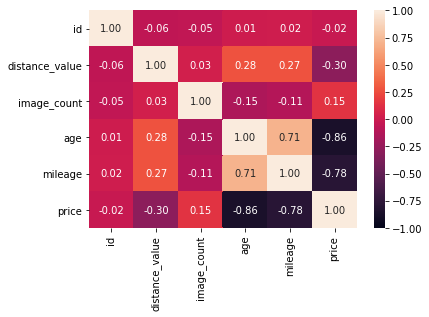

In [ ]:
# Compute corr matrix.  Manually set the order
corr_mat = df[['id',
                'distance_value',
                'image_count',
                'age',
                'mileage',
                'price']].corr() 
 
# Plot a colour coded heat map of Pearson correlation coef
sns.heatmap(corr_mat, vmax=1, vmin=-1, annot=True, fmt='.2f');
 
def saveplot(name='plot.png'):
   if ~name.endswith('.png'):
      name = name + '.png'
   plt.savefig(os.path.join(path,name), bbox_inches='tight')
 
saveplot('corrmat')

- **image_count:** Correlates slightly with age and mileage, which suggests newer, lower mileage cars (which tend to be high-value) also tend to be more professionally presented with loads of photos.  So the image count isn't really an independent feature to prioritize.
- **distance_value:** Correlates strongly with age and mileage.  It seems that Glasgow (or perhaps anywhere away from the large population centres in England) has a disproportionately lower proportion of young, newish Audi A6s on sale vs places like London.  I don't think it's particularly the location that drives this price trend, but most of the large new car dealerships will be based on England, whereas Scotland is far less densely populated.

### Visualise with a pair plot

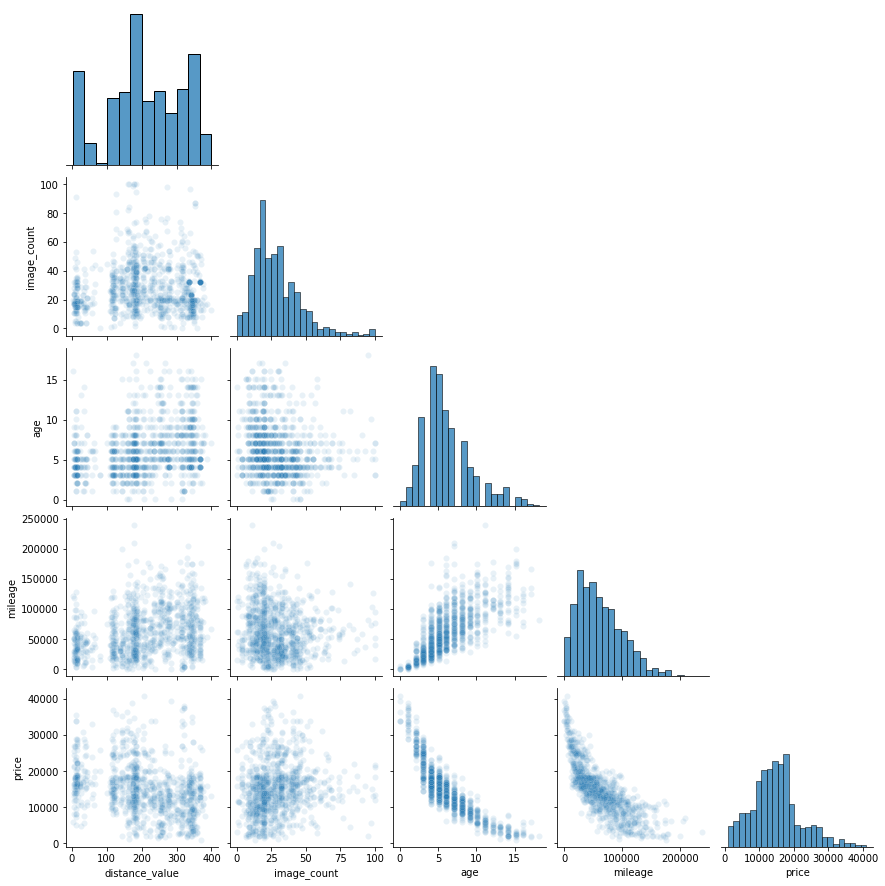

In [ ]:
sns.pairplot(data=df[['distance_value','image_count','age','mileage','price'                  
                      ]], corner=True, plot_kws={'alpha':0.1});
saveplot('pairplot')

Looking mainly at the bottom row against `price`
- As expected, id number is just a random number and not useful for analysis
- mileage and age both have logarythmic type correlations with price, and are prime candidates for model building (correlation coefficients were around -0.8)
- 

### Price vs mileage

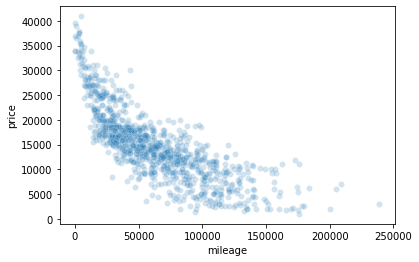

In [ ]:
sns.scatterplot(data=df,x='mileage',y='price', alpha=0.2);

### Price vs Year

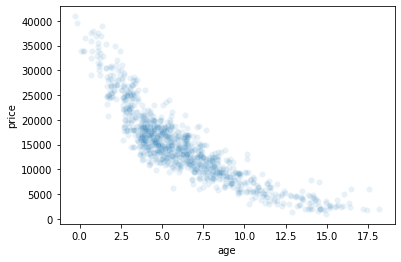

In [ ]:
# Add a jitter func to reduce the "steppy-ness" of the age (since 'age' counts in whole years)
def jitter(x,amount=1):
  return x + (np.random.random_sample(len(x))-0.5) * amount 

sns.scatterplot(data=df, x=jitter(df.age,1), y='price', alpha=0.1);

Will definitely need to center this data with setting like StandardScaler, since the values are calendar years, they are miles away from the origin, and some models will behave badly due to this.

### Year vs mileage vs price (colour)

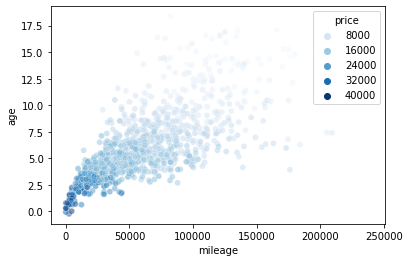

In [ ]:
sns.scatterplot(data=df, x='mileage', y=jitter(df.age,1), hue='price', alpha=0.5, palette='Blues');

### Image count

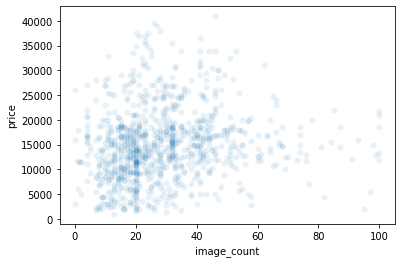

In [ ]:
sns.scatterplot(data=df, x='image_count', y='price', alpha=0.1);

Not much of a correlation between price vs image_count, but it had a reasonable Pearson correlation coefficient of 0.2

## Engine size

In [ ]:
# Use Regex to extract engine size
def extractEngineSize(val,r):
  m = r.match(val)
  if m is not None:
    return m.groups()[0]
  else: 
    return ''

r = re.compile('.*([0-9].[0-9])L')
engine_asstrings = df.key_spec_list_ad.apply(extractEngineSize,r=r)

df['engine_size'] = pd.to_numeric(engine_asstrings)

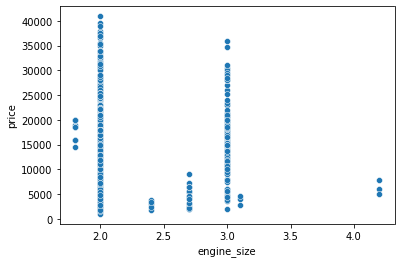

In [336]:
sns.scatterplot(data=df, x='engine_size', y='price');

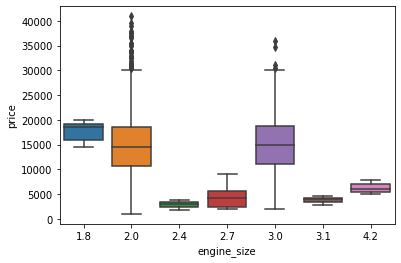

In [339]:
sns.boxplot(data=df, x='engine_size', y='price');

Most recent Audi A6 models have consolidated to 2.0 and 3.0 engine sizes.  so the in-between sizes like 2.4, 2.7 etc were probably only available on mainly older, lower priced cars.  Perhaps this category makes more sense as a categorical one rather than a continuous numerical one, since it's not a uniform trend really.  At least then it can learn a rule like: if engine size ==2.4, then  price will likely be below £5000.

In [338]:
# Reassign to category type
df.engine_size = df.engine_size.astype('category')

In [346]:
# Fill any unknown with "unknown"
df.engine_size = df.engine_size.cat.add_categories(-1)
df.engine_size = df.engine_size.fillna(-1)

<a name="data-exploration-categorical"></a>
# Data exploration (categorical)

Reminder of what categorical features we have

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985 entries, 0 to 1098
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   attention_grabber     905 non-null    object        
 1   condition_value       985 non-null    category      
 2   description_full      985 non-null    object        
 3   detail_ad             985 non-null    object        
 4   distance_value        985 non-null    int64         
 5   good_great_value      985 non-null    category      
 6   id                    985 non-null    int64         
 7   image_count           985 non-null    int64         
 8   key_spec_list_ad      985 non-null    object        
 9   price                 985 non-null    int64         
 10  seller_location       956 non-null    object        
 11  seller_private_trade  985 non-null    category      
 12  time_of_scrape        985 non-null    datetime64[ns]
 13  title_ad           

Check unique categories for "condition_value" and "good_great_value"


In [ ]:
df.condition_value.value_counts()

Blank                     985
New car: Available now      0
Name: condition_value, dtype: int64

In [ ]:
df.good_great_value.value_counts()

noanalysis    985
Name: good_great_value, dtype: int64

Both "condition_value" and "good_great_value" are pretty useless, all seems to be one value.  Let's drop these columns


In [ ]:
df = df.drop(labels=['condition_value','good_great_value'],axis=1)

## Aggregate "seller_private_trade" 

Do the same for "seller_private_trade"

In [ ]:
df.seller_private_trade.value_counts()

Private seller                187
Big Motoring World             23
Carshop Click and Collect      21
Big Motoring World Enfield     13
Cazoo                          11
                             ... 
Motors 2 You                    1
Mototom Cars Ltd                1
NEWLOOKCARS LTD                 1
3X Motors Ltd                   1
SK Autobahn                     0
Name: seller_private_trade, Length: 521, dtype: int64

This looks more promising, we aren't really interested in specific dealerships, so let's aggregate everything into "private seller" or "trade seller"

In [ ]:
df.seller_private_trade = df.seller_private_trade.agg(lambda x: 'Private seller' if x == 'Private seller' else 'Trade seller').astype('category')

In [ ]:
# Check value counts after aggregating
df.seller_private_trade.value_counts()

Trade seller      798
Private seller    187
Name: seller_private_trade, dtype: int64

## Add new_used
Seems useful to be able to separate out new/nearly new vehicles from used ones. New cars could skew the results as they are outliers.

It turns out there are only 6 cars less than 1 year old.  I probably searched for "Used cars only" when I grabbed the autotrader search URL.

Should be OK to leave these rows in for modelling.

In [ ]:
df['new_used'] = df.age.apply(lambda x: 'New' if x < 1 else 'Used').astype('category')
df.new_used.value_counts()

Used    979
New       6
Name: new_used, dtype: int64

## Correlations
Let's visualise the trend in price, based on these categories feature

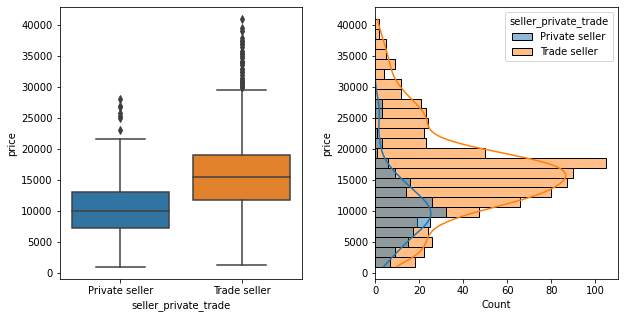

In [ ]:
import matplotlib.pyplot as plt
 
def plotBinaryPrice(param,df=df,sizew=10,sizeh=5,title=''):
  fig, ax = plt.subplots(1,2)
  fig.set_size_inches(sizew,sizeh)
  fig.subplots_adjust(wspace=0.3)
  sns.boxplot(data=df,x=param,y='price',ax=ax[0]);
  sns.histplot(data=df,y='price',hue=param,kde=True, ax=ax[1]);
  if title is not '':
    fig.suptitle(title)
 
plotBinaryPrice('seller_private_trade')
saveplot('privatevstrade')

"seller_private_trade" correlates strongly with price.
- Private cars had a median price of £10,000, vs a median of >£15,000 for Trade cars.
- The top 75% quartile of private cars was around £22,000 vs a 75% quartile of £30,000 for trade cars
- In general trade cars are priced significantly higher than private cars.  
 - Though there may be underlying differences in the types of vehicles that trade sellers tend to sell, maybe they only sell younger, more expensive cars anyway?  See later.

**Correllation vs causation?**  Are trade cars more expensive **because** they are trade cars... or is it because they are generally newer & lower mileage?

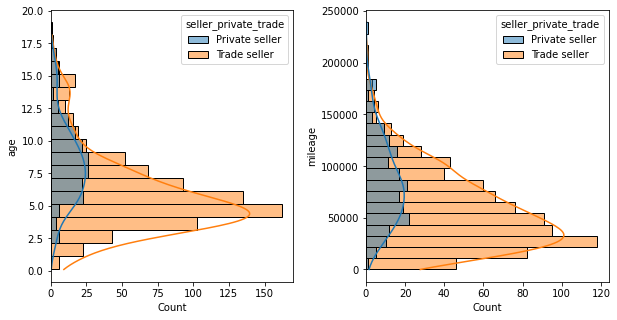

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,5)
fig.subplots_adjust(wspace=0.3)
sns.histplot(data=df, y='age', hue='seller_private_trade', kde=True, ax=ax[0], binwidth=1);
sns.histplot(data=df, y='mileage', hue
='seller_private_trade', kde=True, ax=ax[1]);
saveplot('privatevstrade_agemileage')

So it does indeed look like private cars are generally older, and higher mileage than trade cars.  So the influence directly from trade vs private sellers, is probably smaller than it looks in the previous set of plots.

Anyway, we will keep this feature in the dataframe for modelling, incase it helps pick out some subtler distinction between the categories.

Let's look at "new" vs "used" in the same way

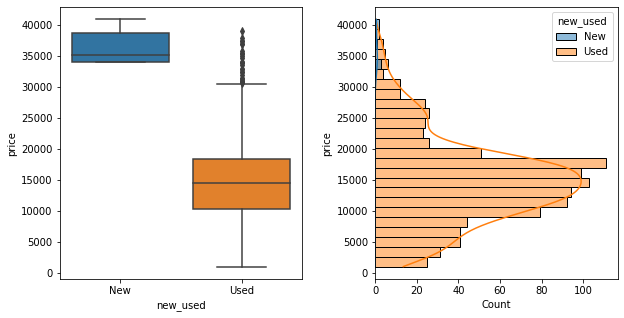

In [ ]:
plotBinaryPrice('new_used')

"new_used" correlates strongly with price also with new cars being way at the top end of the scale in price. However the sample size for the "new" category is **really** small.  From intuition, there would be very few "new" cars with low prices so this conclusion does make sense anyway.  

Again asking the **Correllation vs causation** question?  Are "new" cars actually more expensive because because they are generally low mileage?

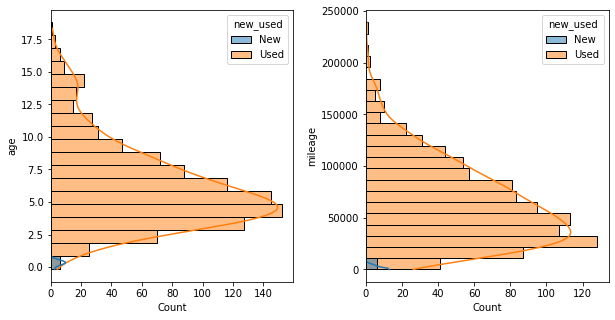

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,5)
fig.subplots_adjust(wspace=0.3)
sns.histplot(data=df, y=jitter(df.age,1), hue='new_used', kde=True, ax=ax[0], binwidth=1);
sns.histplot(data=df, y='mileage', hue='new_used', kde=True, ax=ax[1]);

Looks like it could be the case yes, "new" cars have very little mileage, and very little age.  So it makes sense the cars would be expensive based on these 2 factors alone, regardless of whether it was classed as a "new" (younger than 1 year) or "used" car.

We will also keep this categorical feature in the dataframe so the model can capture the subtlety in this trend like with "Private" vs "Trade".

Lets plot a gird of scatter plots for **price vs mileage** alongside **price vs age**.  Colour it by each of these categories to see the above trends in a different way.

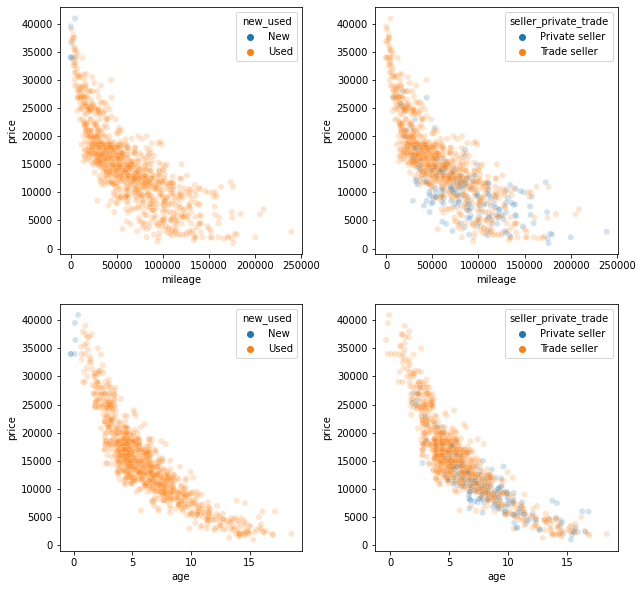

In [ ]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(10,10)
fig.subplots_adjust(wspace=0.3)
sns.scatterplot(data=df,x='mileage',y='price',hue='new_used',alpha=0.2,ax=ax[0][0]);
sns.scatterplot(data=df,x='mileage',y='price',hue='seller_private_trade',alpha=0.2,ax=ax[0][1]);

sns.scatterplot(data=df,x=jitter(df.age,1),y='price',hue='new_used',alpha=0.2,ax=ax[1][0]);
sns.scatterplot(data=df,x=jitter(df.age,1),y='price',hue='seller_private_trade',alpha=0.2,ax=ax[1][1]);


**The top row of plots are price vs mileage**.  
- "New" cars only exist in a cluster at the top left on chart 1.  
- "Private" cars have a wider spread (and a bigger sample size), but generally occupy the higher mileage, lower price side of plot.  
- There also seems to be a broader spread, less linear looking correlation with "Private" cars in the right hand chart.

**The bottom row of plots are price vs age**.  
- Same kind of clustering, "New" cars are in a cluster at the top left (high price, low age). 
- In the right hand chart,  "Private" cars are generally older ones.
- Also worth noting the correlation seems stronger between price vs age than it does. And this remains true whether "Private" or "Trade", unlike with mileage.
 - I think this is showing clearly that age is the strongest feature in predicting selling price.

# Feature extraction from text

## Full Service History
Cars that are well maintained are often marketed as "FSH" for full service history

In [ ]:
df.attention_grabber = df.attention_grabber.fillna('')
df.attention_grabber = df.attention_grabber.str.strip("'")
df.attention_grabber = df.attention_grabber.str.lower()

In [ ]:
df['is_fsh'] = df.attention_grabber.str.contains(pat='full service history|fsh|service history', regex=True)

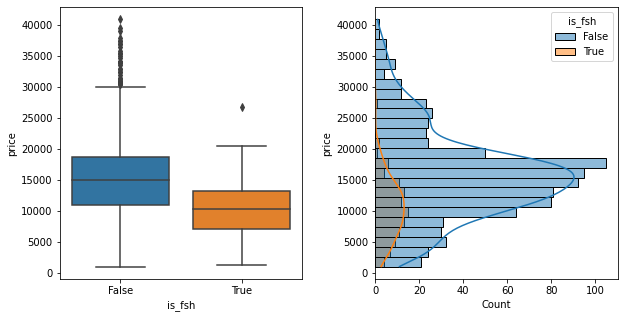

In [ ]:
plotBinaryPrice('is_fsh')
saveplot('fsh')

On first glance it looks like the service history makes a big difference to the price.  However let's also bring context of the age and mileage associated with cars that are marketed as "fsh"

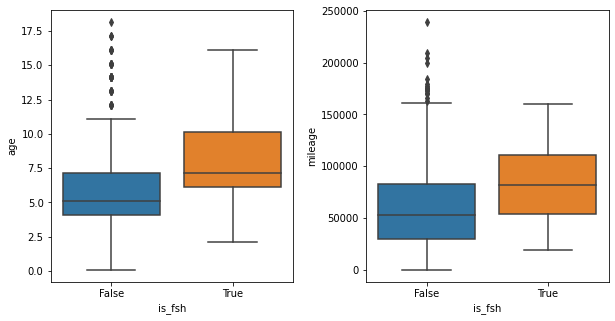

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,5)
fig.subplots_adjust(wspace=0.3)
sns.boxplot(data=df,x='is_fsh',y='age',ax=ax[0]);
sns.boxplot(data=df,x='is_fsh',y='mileage',ax=ax[1]);

As I suspected, cars that are fairly new, are **expected** to be well maintained anyway.  So only sellers of older, higher mileage cars tend to bother mentioning the service history for those cars.  

It's possible that a trained model will pick out that this parameter is useful for older cars.  Let's try to plot the above price trend, filtering down to only older cars.

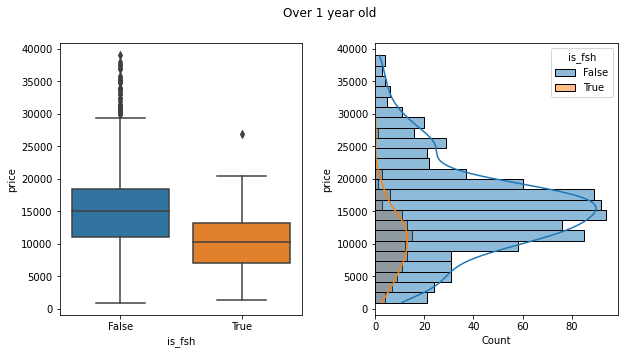

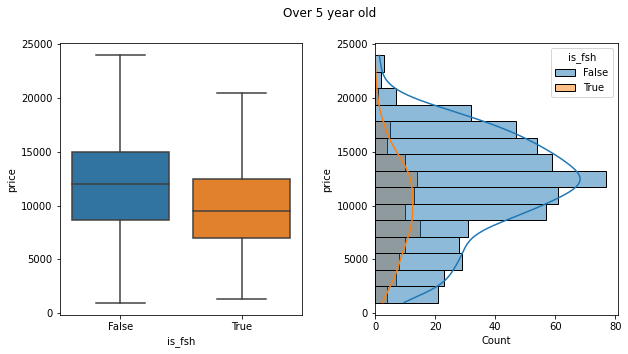

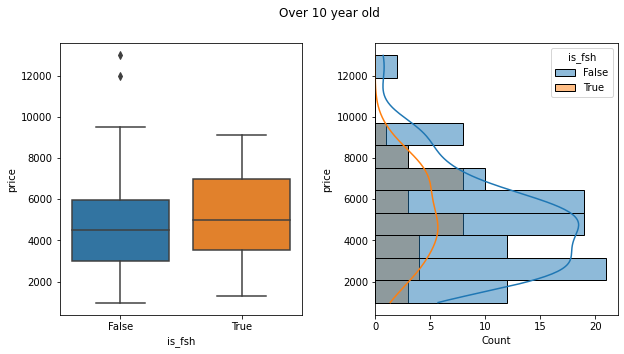

In [314]:
# Over 1 yr old
plotBinaryPrice('is_fsh',df[df.age > 1],title='Over 1 year old')
 
# Over 5 yr old
plotBinaryPrice('is_fsh',df[df.age > 5],title='Over 5 year old')
 
# Over 10 yr old
plotBinaryPrice('is_fsh',df[df.age > 10],title='Over 10 year old')
saveplot('fsh10yr')

We see from row 1 that cars over 1 year old (which is most cars in this dataset) are higher priced when FSH is not in the headline description.

In row 2 we see that cars over 5 years old are similar, but looks like the difference is less significant, with more overlap in the boxplots

In row 3 we see that cars over 10 years old are the opposite trend, more expensive cars of this age, tend to be marketed with FSH in the description.

I would like to see if a well trained model could pick out this relationship, so will keep this categorical feature in.

## TDI engine


In [ ]:
df.detail_ad = df.detail_ad.str.lower()

In [ ]:
df['is_tdi'] = df.detail_ad.str.contains('tdi')

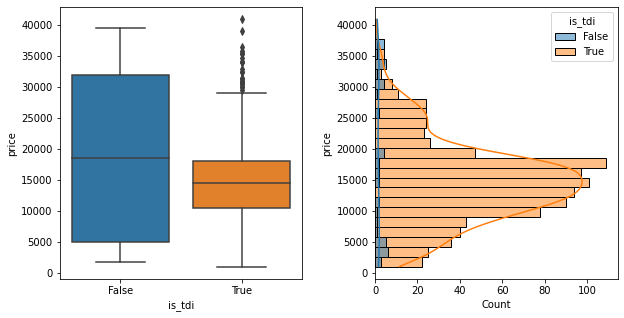

In [ ]:
plotBinaryPrice('is_tdi')

Looks like most adverts in the dataset are "`is_tdi=True`"

So no obvious trend on this feature alone.


## Quattro

In [ ]:
df['is_quattro'] = df.detail_ad.str.contains('quattro')

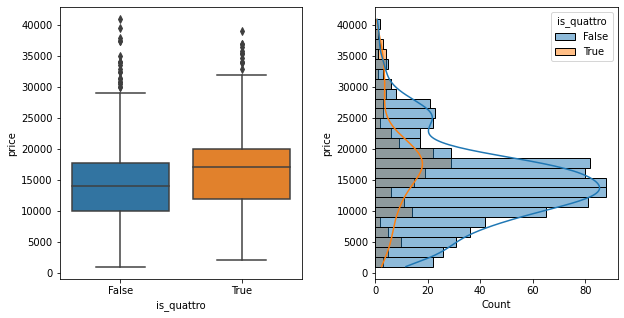

In [ ]:
plotBinaryPrice('is_quattro')
saveplot('quattro')

It's not the strongest of trends, but there definitely looks like price generally is higher for those ads mentioning quattro.

## Black edition models

In [ ]:
df['is_black_edition'] = df.detail_ad.str.contains('black edition')

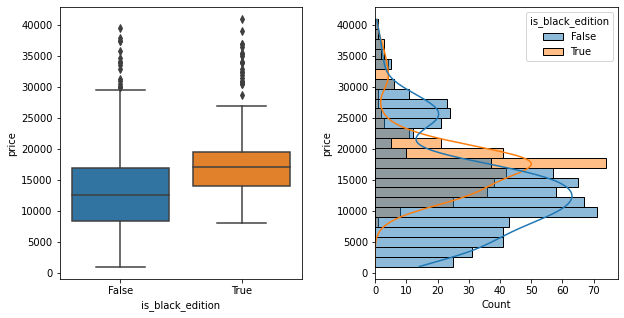

In [ ]:
plotBinaryPrice('is_black_edition')

This time it's as clear as day, cars that are described as "black edition" models definitely tend to be more expensive than ones that are not.

## Ultra models

In [ ]:
df['is_ultra'] = df.detail_ad.str.contains('ultra')

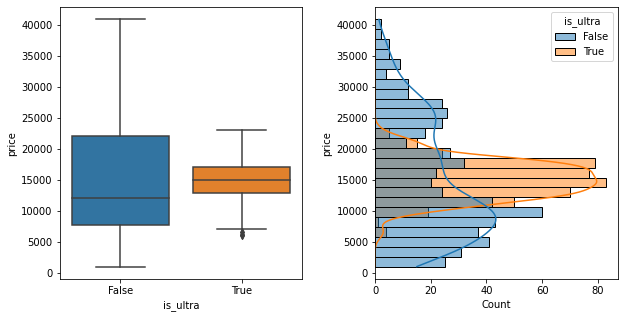

In [ ]:
plotBinaryPrice('is_ultra')

So there's a much bigger spread in price for cars described as "ultra" models, but there's definitely a strong peak around the £15,000 price mark for cars labelled as Ultra.

## "S line" models

In [ ]:
df['is_s_line'] = df.detail_ad.str.contains('s line|sline|s-line')

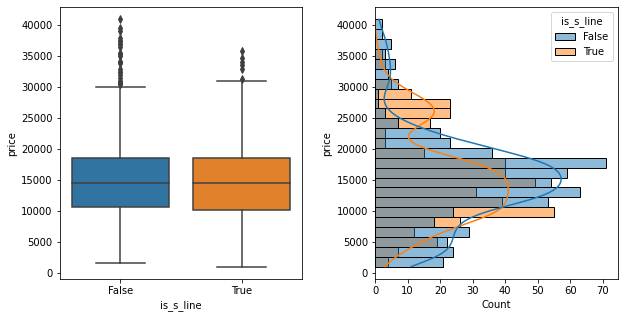

In [ ]:
plotBinaryPrice('is_s_line')

It seems almost the same number of cars with and without s-line, but overall, it looks like s-line probably won't be a useful parameter for distinguishing the high/low price cars.

## MOT

In [ ]:
df['is_mot'] = (df.detail_ad.str.contains('mot') | df.attention_grabber.str.contains('mot'))

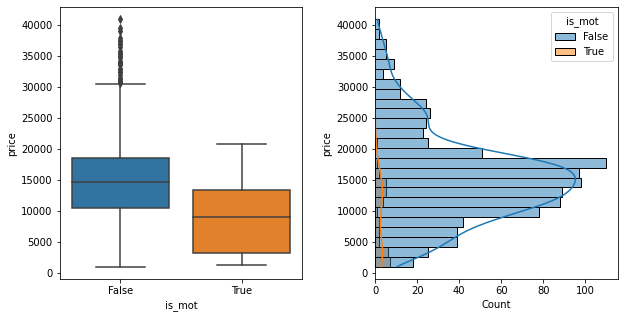

In [ ]:
plotBinaryPrice('is_mot',df=df)

Overall it looks like there is a negative trend in price when "mot" is mentioned in the advert summary.

But what if this feature has a different effect on privately sold, vs trade sold cars?

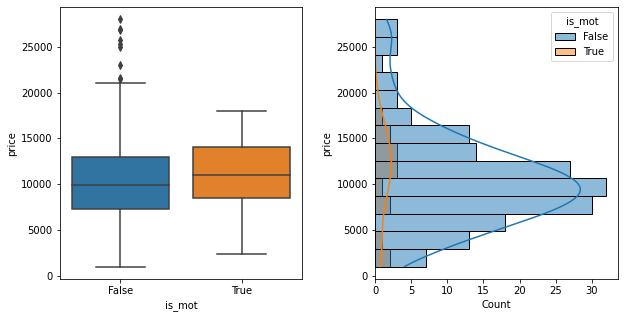

In [ ]:
plotBinaryPrice('is_mot',df=df[df.seller_private_trade.str.contains('Private')])

As suspected, in the subset of cars which are sold privately only (which as we know already are typically older and higher mileage), price is generally higher when mot is mentioned in the advert summary.

**Caution:** the sample size for mot=True under privately sold cars here is quite small.

## Model rev
Calculate model rev using `pd.cut()` according to the launch dates on Wikipedia. 

In [ ]:
import datetime

revdict = {'older':datetime.datetime(1990,1,1),
           'C4':datetime.datetime(1994,1,1),
           'C5':datetime.datetime(2002,1,1),
           'C5.5':datetime.datetime(2004,1,1),
           'C6':datetime.datetime(2011,1,1),
           'C7':datetime.datetime(2018,1,1),
           'C8':datetime.datetime(2023,1,1)
          }
revdates = pd.to_datetime(list(revdict.values()))
revlabels = list(revdict.keys())
revlabels.pop(0)
year = pd.to_datetime(df.year,format='%Y')

df['model_rev'] = pd.cut(year,bins=revdates,labels=revlabels)

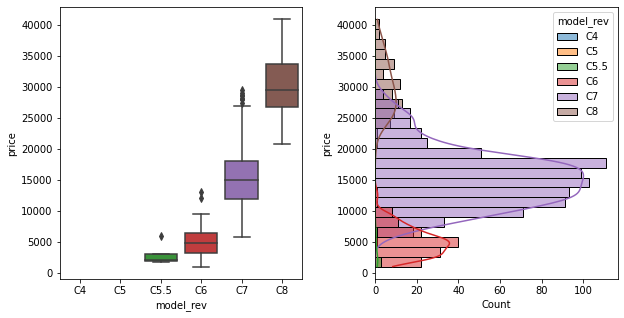

In [ ]:
plotBinaryPrice('model_rev')
saveplot('modelrev')

## Export at checkpoint

In [ ]:
df.to_pickle(os.path.join(path,'df_checkpoint1.pkl'))

<a name="model-building-simple"></a>
# Model building (simple)
First we will build a model based only on mileage and age, which were the two most predictive features from the exploratory analysis.  This will form a baseline prediction based on 2 easy to understand features, so any weird interactions are easy to investigate.

Later we will build an enhanced model which uses more of the complex features generated during feature extraction.


## Import at checkpoint

In [542]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 
path = os.path.join('drive','MyDrive','Data', 'autotrader')
df = pd.read_pickle(os.path.join(path,'df_checkpoint1.pkl'))

In [543]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder 
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
# from sklearn.metrics import accuracy_score, plot_confusion_matrix, f1_score 
# from sklearn.metrics import plot_roc_curve, roc_auc_score, precision_score, recall_score
# from sklearn.metrics import precision_recall_fscore_support, plot_precision_recall_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.inspection import permutation_importance
 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR

In [544]:
# train split
X = df[['mileage','age']]
#X = df.drop('price', axis=1)
y = df['price']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear regression

In [545]:
# Define a model pipeline
num_features = ['mileage','age']
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])
 
preprocessor = ColumnTransformer([('nums', num_transformer, num_features)],
                                 remainder='drop')
 
linreg = Pipeline([('preprocessor', preprocessor),
                       ('reg', LinearRegression())])

**Evaluate model:** Run cross validation and print mean/std-dev
Plot prediction curve over mileage and year features.  For a bivariate scatterplot keep the other feature constant (use median value from the training set) and predict across the whole range of each feature.  

Repeat this over different quartile values to get an idea of the response surface.

In [546]:
# make a function to speed up model evaluation
def evaluate_reg(reg,reg_name):
   reg.fit(X_train,y_train);
   y_train_pred = reg.predict(X_train)
   y_test_pred = reg.predict(X_test)
   cv_scores = cross_val_score(reg,X_train,y_train)
   mae_test = mean_absolute_error(y_test, y_test_pred)
   mse_test = mean_squared_error(y_test, y_test_pred)
   r2_test = r2_score(y_test, y_test_pred)
 
   # Generate a little report
   print(f'model-name:.  {reg_name}')
   print(f'cv_scores:.   {cv_scores}')
   print(f'cv_mean:      {cv_scores.mean():.3f}')
   print(f'cv_stdev:     {cv_scores.std():.3f}')
   print(f'mae_test:     {mae_test:.3f}')
   print(f'mse_test:     {mse_test:.3f}')
   print(f'r2_test:      {r2_test:.3f}')

 
   eval_dict = {'name':reg_name,
                'cv_mean':cv_scores.mean(),
                'cv_std':cv_scores.std(),
                'mae_test':mae_test,
                'mse_test':mse_test,
                'r2_test':r2_test,
                }
 
   fig, ax = plt.subplots(1,2)
   fig.set_size_inches(13,5)
   reg.fit(X_train,y_train)
   mileage0 = np.linspace(X_train.mileage.min(),X_train.mileage.max(),10)
 
   for q in [0,0.25,0.5,0.75,1]:
      age0 = X_train.age.quantile(q)*np.ones(len(mileage0))
 
      X0 = pd.DataFrame(np.c_[mileage0,age0],columns=['mileage','age'])
      y0 = reg.predict(X0)
      ax[0].plot(X0.mileage,y0,label=str(q));
 
   ax[0].plot(X_train.mileage,y_train,'.',alpha=0.2);
   ax[0].set_xlabel('mileage');
   ax[0].set_ylabel('price');
   ax[0].set_xlim([min(X_train.mileage),max(X_train.mileage)])
   ax[0].set_ylim([min(y_train),max(y_train)])
   ax[0].legend();
 
   age1 = np.linspace(X_train.age.min(),X_train.age.max(),10)
 
   for q in [0,0.25,0.5,0.75,1]:
     mileage1 = X_train.mileage.quantile(q)*np.ones(len(age1))
     X1 = pd.DataFrame(np.c_[mileage1,age1],columns=['mileage','age'])
     y1 = reg.predict(X1)
     plt.plot(X1.age,y1,label=str(q));
 
   ax[1].plot(X_train.age,y_train,'.',alpha=0.2);
   ax[1].set_xlabel('age');
   ax[1].set_ylabel('price');
   ax[1].set_xlim([min(X_train.age),max(X_train.age)])
   ax[1].set_ylim([min(y_train),max(y_train)])
   ax[1].legend();
   
   return eval_dict

model-name:.  linreg basic
cv_scores:.   [0.79876119 0.78151348 0.81206002 0.81757862 0.80330447]
cv_mean:      0.803
cv_stdev:     0.012
mae_test:     2245.163
mse_test:     9480894.574
r2_test:      0.813


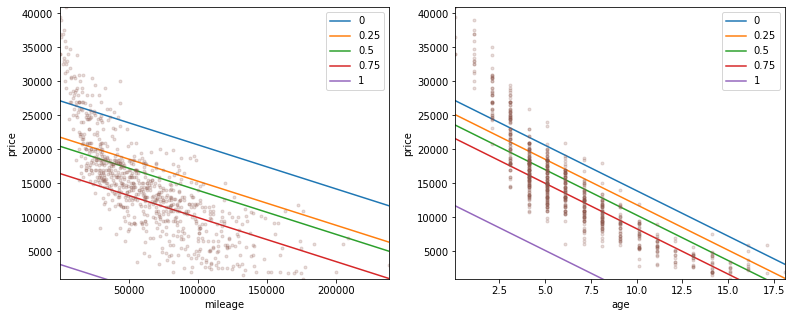

In [547]:
eval_dict = evaluate_reg(linreg,
                         'linreg basic');

In [548]:
df_eval = pd.DataFrame(columns=['name','cv_mean','cv_std','mae_test','mse_test','r2_test'])
df_eval = df_eval.append(eval_dict,ignore_index=True)

## Linear reg with poly features

In [549]:
# Define a model pipeline
num_features = ['mileage','age']
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=2))])
 
preprocessor = ColumnTransformer([('nums', num_transformer, num_features)],
                                 remainder='drop')
 
linregpoly = Pipeline([('preprocessor', preprocessor),
                       ('reg', LinearRegression())])

model-name:.  linreg with poly features
cv_scores:.   [0.87564308 0.86455887 0.88147868 0.88378882 0.88481105]
cv_mean:      0.878
cv_stdev:     0.007
mae_test:     1736.649
mse_test:     5416146.672
r2_test:      0.893


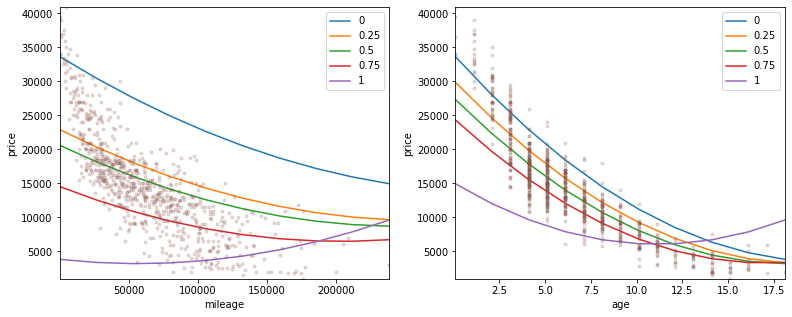

In [550]:
eval_dict = evaluate_reg(linregpoly,
                         'linreg with poly features');

In [551]:
df_eval = df_eval.append(eval_dict,ignore_index=True)

## Elastic-Net

In [552]:
# Define a model pipeline
num_features = ['mileage','age']
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=5))])
 
preprocessor = ColumnTransformer([('nums', num_transformer, num_features)],
                                 remainder='drop')
 
linregpoly = Pipeline([('preprocessor', preprocessor),
                       ('reg', ElasticNet(max_iter=10000,alpha=20, l1_ratio=0.9))])

model-name:.  Elastic-net
cv_scores:.   [0.77581505 0.84265095 0.81502169 0.77318749 0.8371419 ]
cv_mean:      0.809
cv_stdev:     0.029
mae_test:     2426.461
mse_test:     8934010.581
r2_test:      0.824


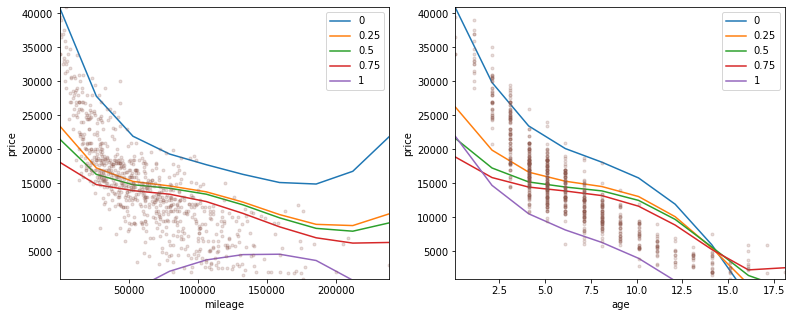

In [553]:
eval_dict = evaluate_reg(linregpoly,
             'Elastic-net');

In [554]:
df_eval = df_eval.append(eval_dict,ignore_index=True)

## KNN
k nearest neighbours

In [555]:
# Define a model pipeline
num_features = ['mileage','age']
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])
 
preprocessor = ColumnTransformer([('nums', num_transformer, num_features)],
                                 remainder='drop')
 
knnreg = Pipeline([('preprocessor', preprocessor),
                       ('knn', KNeighborsRegressor())])

model-name:.  knn basic
cv_scores:.   [0.8846559  0.87619622 0.89533566 0.87151163 0.91245577]
cv_mean:      0.888
cv_stdev:     0.015
mae_test:     1745.239
mse_test:     4919000.606
r2_test:      0.903


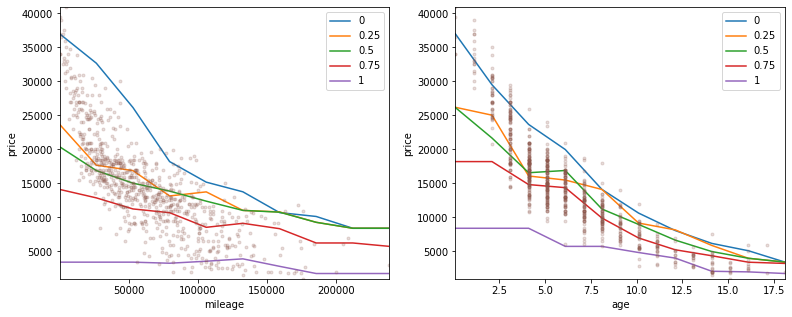

In [556]:
eval_dict = evaluate_reg(knnreg,
             'knn basic');

In [557]:
df_eval = df_eval.append(eval_dict,ignore_index=True)

## KNN with poly features

In [558]:
# Define a model pipeline
num_features = ['mileage','age']
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=2))])
 
preprocessor = ColumnTransformer([('nums', num_transformer, num_features)],
                                 remainder='drop')
 
knnregpoly = Pipeline([('preprocessor', preprocessor),
                       ('reg', KNeighborsRegressor())])

model-name:.  knn with poly features
cv_scores:.   [0.88466215 0.87902855 0.89761697 0.87273445 0.91610118]
cv_mean:      0.890
cv_stdev:     0.015
mae_test:     1729.914
mse_test:     4781171.004
r2_test:      0.906


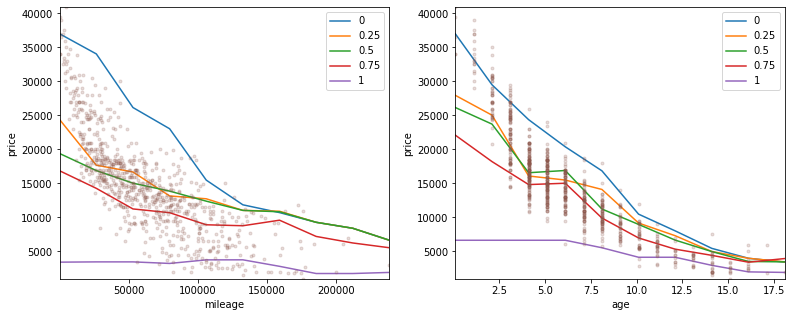

In [559]:
eval_dict = evaluate_reg(knnregpoly,
             'knn with poly features');

In [560]:
df_eval = df_eval.append(eval_dict,ignore_index=True)

## SVR

In [561]:
# Define a model pipeline
num_features = ['mileage','age']
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler()),
                       #     ('poly', PolynomialFeatures(degree=2))
])
 
preprocessor = ColumnTransformer([('nums', num_transformer, num_features)],
                                 remainder='drop')
 
svmreg = Pipeline([('preprocessor', preprocessor),
                   ('reg', LinearSVR())])

model-name:.  Linear SVR
cv_scores:.   [-4.01043    -3.71621481 -4.25369392 -4.06277236 -3.61162342]
cv_mean:      -3.931
cv_stdev:     0.235
mae_test:     14439.320
mse_test:     259166973.371
r2_test:      -4.114


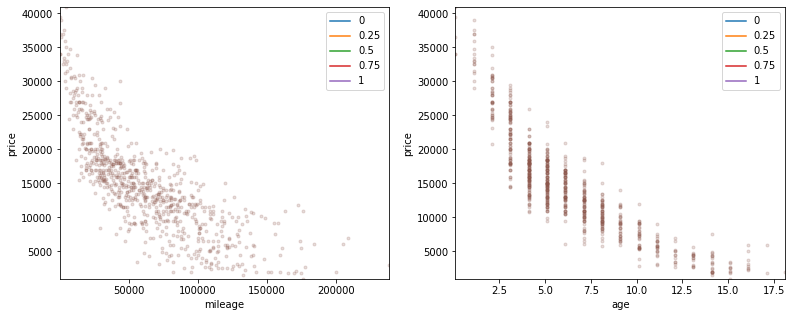

In [562]:
eval_dict = evaluate_reg(svmreg,'Linear SVR');

In [563]:
# Don't add this result to the comparison table as it's wayyy off
# df_eval = df_eval.append(eval_dict,ignore_index=True)

This result didn't make much sense.  It looks like the default training parameters C and gamma need some tweaking to get the SVR model to reasonably fit the data.  We will try a gridsearch tuned version of this model next.

## SVR alternative

In [564]:
from sklearn.svm import SVR
# Define a model pipeline
num_features = ['mileage','age']
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=2))
])
 
preprocessor = ColumnTransformer([('nums', num_transformer, num_features)],
                                 remainder='drop')
 
svrreg = Pipeline([('preprocessor', preprocessor),
                   ('reg', SVR(epsilon=0.000001))])

model-name:.  SVR alternative
cv_scores:.   [ 0.01228418  0.00934897 -0.00172518  0.00560163  0.00895545]
cv_mean:      0.007
cv_stdev:     0.005
mae_test:     5346.679
mse_test:     50536757.073
r2_test:      0.003


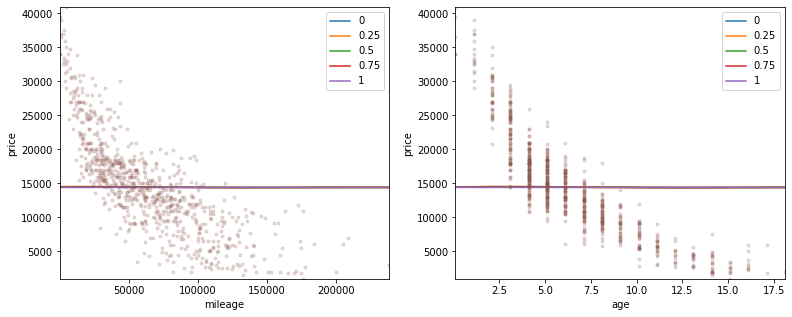

In [565]:
eval_dict = evaluate_reg(svrreg,'SVR alternative');

In [566]:
df_eval = df_eval.append(eval_dict,ignore_index=True)

## SVR tuned

In [567]:
# Takes about 30 seconds to run on Google Colab
param_grid = {'reg__C':[0.1,10,100,1000,10000,100000,1000000],
              'reg__gamma':[0.001,0.01,0.1,1,10]}
 
svrgrid = GridSearchCV(svrreg,param_grid,n_jobs=-1)
%time svrgrid.fit(X_train,y_train)
print(f'best params:    {svrgrid.best_params_}')

CPU times: user 1.2 s, sys: 73 ms, total: 1.27 s
Wall time: 34.5 s
best params:    {'reg__C': 100000, 'reg__gamma': 0.01}


model-name:.  svr tuned
cv_scores:.   [0.89301719 0.89758257 0.89733092 0.88726108 0.90770017]
cv_mean:      0.897
cv_stdev:     0.007
mae_test:     1622.795
mse_test:     4529144.219
r2_test:      0.911


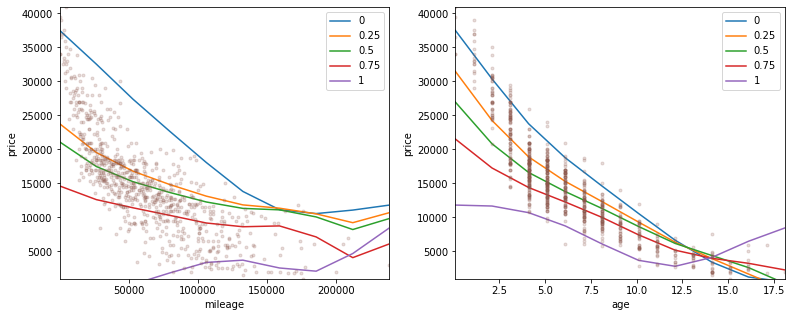

In [568]:
eval_dict = evaluate_reg(svrgrid.best_estimator_,'svr tuned')

In [569]:
df_eval = df_eval.append(eval_dict,ignore_index=True)

## Decision Tree

In [570]:
from sklearn.tree import DecisionTreeRegressor
 
# Define a model pipeline
num_features = ['mileage','age']
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=3))
])
 
preprocessor = ColumnTransformer([('nums', num_transformer, num_features)],
                                 remainder='drop')
 
tree = Pipeline([('preprocessor', preprocessor),
                   ('tree', DecisionTreeRegressor())])

model-name:.  Tree
cv_scores:.   [0.86209078 0.85741068 0.86717382 0.83867164 0.8931771 ]
cv_mean:      0.864
cv_stdev:     0.018
mae_test:     1863.783
mse_test:     5678876.784
r2_test:      0.888


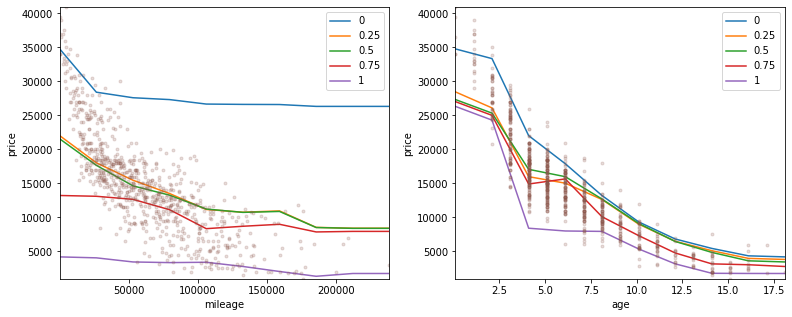

In [571]:
eval_dict = evaluate_reg(forestreg,'Tree')

In [572]:
df_eval = df_eval.append(eval_dict,ignore_index=True)

## Random forest

In [573]:
from sklearn.ensemble import RandomForestRegressor
 
# Define a model pipeline
num_features = ['mileage','age']
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler()),
                       #     ('poly', PolynomialFeatures(degree=2))
])
 
preprocessor = ColumnTransformer([('nums', num_transformer, num_features)],
                                 remainder='drop')
 
forestreg = Pipeline([('preprocessor', preprocessor),
                   ('reg', RandomForestRegressor())])

model-name:.  Forest
cv_scores:.   [0.86121864 0.86282795 0.86854876 0.84047011 0.89472813]
cv_mean:      0.866
cv_stdev:     0.017
mae_test:     1866.677
mse_test:     5687722.687
r2_test:      0.888


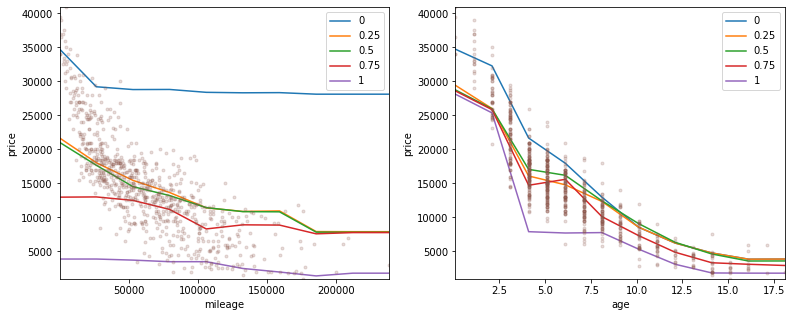

In [574]:
eval_dict = evaluate_reg(forestreg,'Forest')

In [575]:
df_eval = df_eval.append(eval_dict,ignore_index=True)

## Comparison table

In [576]:
# df_eval.cv_std.plot()
# plt.ylim([0,0.2])
df_eval

,name,cv_mean,cv_std,mae_test,mse_test,r2_test
0,linreg basic,0.802644,0.012440,2245.163328,9.480895e+06,0.812901
1,linreg with poly features,0.878056,0.007459,1736.649035,5.416147e+06,0.893116
2,Elastic-net,0.808763,0.029476,2426.461171,8.934011e+06,0.823693
3,knn basic,0.888031,0.014658,1745.238579,4.919001e+06,0.902927
4,knn with poly features,0.890029,0.015403,1729.913706,4.781171e+06,0.905647
5,SVR alternative,0.006893,0.004802,5346.679434,5.053676e+07,0.002689
6,svr tuned,0.896578,0.006705,1622.794916,4.529144e+06,0.910620
7,Tree,0.863705,0.017604,1863.783453,5.678877e+06,0.887931
8,Forest,0.865559,0.017410,1866.676552,5.687723e+06,0.887756


In [577]:
df_eval.to_markdown()

'|    | name                      |    cv_mean |     cv_std |   mae_test |    mse_test |    r2_test |\n|---:|:--------------------------|-----------:|-----------:|-----------:|------------:|-----------:|\n|  0 | linreg basic              | 0.802644   | 0.0124396  |    2245.16 | 9.48089e+06 | 0.812901   |\n|  1 | linreg with poly features | 0.878056   | 0.00745929 |    1736.65 | 5.41615e+06 | 0.893116   |\n|  2 | Elastic-net               | 0.808763   | 0.0294758  |    2426.46 | 8.93401e+06 | 0.823693   |\n|  3 | knn basic                 | 0.888031   | 0.0146579  |    1745.24 | 4.919e+06   | 0.902927   |\n|  4 | knn with poly features    | 0.890029   | 0.0154029  |    1729.91 | 4.78117e+06 | 0.905647   |\n|  5 | SVR alternative           | 0.00689301 | 0.0048019  |    5346.68 | 5.05368e+07 | 0.00268901 |\n|  6 | svr tuned                 | 0.896578   | 0.00670467 |    1622.79 | 4.52914e+06 | 0.91062    |\n|  7 | Tree                      | 0.863705   | 0.0176042  |    1863.78 | 5.67888

# Model building (complex)
Include all features

In [578]:
# train split

# Change dtypes for bool features
df.is_fsh = df.is_fsh.astype('category')
df.is_tdi = df.is_tdi.astype('category')
df.is_quattro = df.is_quattro.astype('category')
df.is_black_edition = df.is_black_edition.astype('category')
df.is_ultra = df.is_ultra.astype('category')
df.is_s_line = df.is_s_line.astype('category')

X = df[['mileage','age','seller_private_trade','engine_size','is_fsh','is_tdi','is_quattro','is_black_edition','is_ultra','is_s_line','model_rev']]
y = df['price']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [579]:
# Create evaluation report function
def evaluate_complex(reg,reg_name):
  reg.fit(X_train,y_train);
  y_train_pred = reg.predict(X_train)
  y_test_pred = reg.predict(X_test)
  cv_scores = cross_val_score(reg,X_train,y_train)
  mae_test = mean_absolute_error(y_test, y_test_pred)
  mse_test = mean_squared_error(y_test, y_test_pred)
  r2_test = r2_score(y_test, y_test_pred)

  # Generate a little report
  print(f'model-name:.  {reg_name}')
  print(f'cv_scores:.   {cv_scores}')
  print(f'cv_mean:      {cv_scores.mean():.3f}')
  print(f'cv_stdev:     {cv_scores.std():.3f}')
  print(f'mae_test:     {mae_test:.3f}')
  print(f'mse_test:     {mse_test:.3f}')
  print(f'r2_test:      {r2_test:.3f}')

  eval_dict = {'name':reg_name,
              'cv_mean':cv_scores.mean(),
              'cv_std':cv_scores.std(),
              'mae_test':mae_test,
              'mse_test':mse_test,
              'r2_test':r2_test,
              }

  return eval_dict

## Linear regression

In [580]:
# Define a model pipeline
num_features = ['age','mileage']
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler()),
                            # ('poly', PolynomialFeatures(degree=2))
                            ])

cat_features = ['engine_size','seller_private_trade','model_rev']
cat_transformer = OneHotEncoder(sparse=False,handle_unknown='ignore')

bool_features = ['is_fsh','is_tdi','is_quattro','is_black_edition','is_ultra','is_s_line']
bool_transformer = SimpleImputer(strategy='constant',fill_value=0)

 
preprocessor = ColumnTransformer([('nums', num_transformer, num_features),
                                  ('cats', cat_transformer, cat_features),
                                  ('bool', bool_transformer, bool_features)],
                                 remainder='drop')
 
linreg2 = Pipeline([('preprocessor', preprocessor),
                    ('reg', LinearRegression())])

In [581]:
eval_dict = evaluate_complex(linreg2,'Linreg complex');

ValueError: ignored

In [ ]:
df_eval = pd.DataFrame(columns=['name','cv_mean','cv_std','mae_test','mse_test','r2_test'])
df_eval = df_eval.append(eval_dict,ignore_index=True)

## Linear regression with poly features

In [ ]:
# Define a model pipeline
num_features = ['age','mileage']
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=2))
                            ])

cat_features = ['engine_size','seller_private_trade','model_rev']
cat_transformer = OneHotEncoder(sparse=False,handle_unknown='ignore')

bool_features = ['is_fsh','is_tdi','is_quattro','is_black_edition','is_ultra','is_s_line']
bool_transformer = SimpleImputer(strategy='constant',fill_value=0)

 
preprocessor = ColumnTransformer([('nums', num_transformer, num_features),
                                  ('cats', cat_transformer, cat_features),
                                  ('bool', bool_transformer, bool_features)],
                                 remainder='drop')
 
linreg2poly = Pipeline([('preprocessor', preprocessor),
                    ('reg', LinearRegression())])

In [ ]:
eval_dict = evaluate_complex(linreg2poly,'Linreg complex + poly features');

In [ ]:
df_eval = df_eval.append(eval_dict,ignore_index=True)

## KNN

In [ ]:
# Define a model pipeline
num_features = ['age','mileage']
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=2))
                            ])

cat_features = ['engine_size','seller_private_trade','model_rev']
cat_transformer = OneHotEncoder(sparse=False,handle_unknown='ignore')

bool_features = ['is_fsh','is_tdi','is_quattro','is_black_edition','is_ultra','is_s_line']
bool_transformer = SimpleImputer(strategy='constant',fill_value=0)

 
preprocessor = ColumnTransformer([('nums', num_transformer, num_features),
                                  ('cats', cat_transformer, cat_features),
                                  ('bool', bool_transformer, bool_features)],
                                 remainder='drop')
 
knn2poly = Pipeline([('preprocessor', preprocessor),
                    ('reg', KNeighborsRegressor())])

In [ ]:
eval_dict = evaluate_complex(knn2poly,'KNN complex');

In [ ]:
df_eval = df_eval.append(eval_dict,ignore_index=True)

## SVR
Try with the earlier tuned params from the "simple" SVR model.

In [ ]:
# Define a model pipeline
num_features = ['age','mileage']
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=2))
                            ])

cat_features = ['engine_size','seller_private_trade','model_rev']
cat_transformer = OneHotEncoder(sparse=False,handle_unknown='ignore')

bool_features = ['is_fsh','is_tdi','is_quattro','is_black_edition','is_ultra','is_s_line']
bool_transformer = SimpleImputer(strategy='constant',fill_value=0)

 
preprocessor = ColumnTransformer([('nums', num_transformer, num_features),
                                  ('cats', cat_transformer, cat_features),
                                  ('bool', bool_transformer, bool_features)],
                                 remainder='drop')
 
svr2 = Pipeline([('preprocessor', preprocessor),
                 ('reg', SVR(C=100000, gamma=0.01))])

In [ ]:
eval_dict = evaluate_complex(svr2,'SVR complex');

In [ ]:
df_eval = df_eval.append(eval_dict,ignore_index=True)

## Decision tree

In [ ]:
# Define a model pipeline
num_features = ['age','mileage']
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=2))
                            ])

cat_features = ['engine_size','seller_private_trade','model_rev']
cat_transformer = OneHotEncoder(sparse=False,handle_unknown='ignore')

bool_features = ['is_fsh','is_tdi','is_quattro','is_black_edition','is_ultra','is_s_line']
bool_transformer = SimpleImputer(strategy='constant',fill_value=0)

 
preprocessor = ColumnTransformer([('nums', num_transformer, num_features),
                                  ('cats', cat_transformer, cat_features),
                                  ('bool', bool_transformer, bool_features)],
                                 remainder='drop')
 
tree2 = Pipeline([('preprocessor', preprocessor),
                 ('reg', DecisionTreeRegressor())])

In [ ]:
eval_dict = evaluate_complex(tree2,'Tree complex');

In [ ]:
df_eval = df_eval.append(eval_dict,ignore_index=True)

## Random Forest

In [ ]:
# Define a model pipeline
num_features = ['age','mileage']
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=2))
                            ])

cat_features = ['engine_size','seller_private_trade','model_rev']
cat_transformer = OneHotEncoder(sparse=False,handle_unknown='ignore')

bool_features = ['is_fsh','is_tdi','is_quattro','is_black_edition','is_ultra','is_s_line']
bool_transformer = SimpleImputer(strategy='constant',fill_value=0)

preprocessor = ColumnTransformer([('nums', num_transformer, num_features),
                                  ('cats', cat_transformer, cat_features),
                                  ('bool', bool_transformer, bool_features)],
                                 remainder='drop')
 
forest2 = Pipeline([('preprocessor', preprocessor),
                 ('reg', RandomForestRegressor())])

In [ ]:
eval_dict = evaluate_complex(forest2,'Forest complex');

In [ ]:
df_eval = df_eval.append(eval_dict,ignore_index=True)

In [ ]:
ohe = (forest2['preprocessor'].named_transformers_['cats'])
cat_feature_names = ohe.get_feature_names(input_features=cat_features)

pf = (forest2['preprocessor'].named_transformers_['nums'].named_steps['poly'])
num_feature_names = pf.get_feature_names(input_features=num_features)

feature_names = np.r_[num_feature_names, cat_feature_names, bool_features]

tree_feature_importances = (forest2.named_steps['reg'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
fig.set_size_inches(5,6)
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
# fig.tight_layout()
plt.show()

In [ ]:
result = permutation_importance(forest2, X_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

## Comparison table

In [ ]:
df_eval

In [ ]:
df_eval.to_markdown()